In [1]:
import pandas as pd
import numpy as np
from paths import *
import igraph as ig
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
df = pd.read_csv(OUTPUT_PATH / 'joined_comments.csv')
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

In [3]:
df

,author,subreddit,score,created,link,body
0,u/lisztomania_0,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,It is an über talent that has become an über t...
1,u/JakeTheSandMan,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,“Armada” \n\nI prefer to call them floating hu...
2,u/justnmirrrs,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,"70% of France electricity is nuclear, so it co..."
3,u/liquid_cherry,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,In the United States you can burn the Bible an...
4,u/Grouchy-Bad-4190,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,Good
...,...,...,...,...,...,...
7877793,u/i_thrive_on_apathy,worldnews,0.064655,2024-03-01 01:59:00,https://www.reddit.com/r/worldnews/comments/1b...,American conservatives are also 99% braindead ...
7877794,u/[deleted],worldnews,0.063841,2024-03-01 01:59:00,https://www.reddit.com/r/worldnews/comments/1b...,[removed]
7877795,u/Charming-Engine4430,IsraelPalestine,0.064132,2024-03-01 01:59:00,https://www.reddit.com/r/IsraelPalestine/comme...,But that's not what they're trying to do. They...
7877796,u/Unpleasant_Classic,worldnews,0.063957,2024-03-01 01:59:00,https://www.reddit.com/r/worldnews/comments/1b...,"Nothing to see here, please move along."


In [4]:
df['submission_id'] = df['link'].str.extract(r'/comments/([a-z0-9]+)/')

print(f"Total dataset: {len(df):,} comments")
print(f"Authors: {df['author'].nunique():,}")
print(f"Subreddits: {df['subreddit'].unique()}")
print(f"Submissions: {df['submission_id'].nunique():,}")
print(f"Date range: {df['created'].min()} to {df['created'].max()}")

Total dataset: 7,877,798 comments
Authors: 529,732
Subreddits: ['AskMiddleEast' 'worldnews' 'Palestine' 'lebanon' 'IsraelPalestine'
 'Israel' 'israelexposed' 'IsraelCrimes']
Submissions: 141,665
Date range: 2023-08-01 03:00:00 to 2024-03-01 01:59:00


In [5]:
MAX_AUTHORS = 50000
top_authors = df['author'].value_counts().head(MAX_AUTHORS).index
df = df[df['author'].isin(top_authors)]

print(f"\nFiltered to top {MAX_AUTHORS:,} authors")
print(f"Kept {len(df):,} comments ({len(df)/7877798*100:.1f}% of original)")
print(f"Across {df['submission_id'].nunique():,} unique submissions")


Filtered to top 50,000 authors
Kept 5,871,708 comments (74.5% of original)
Across 137,765 unique submissions


In [6]:
def build_thread_coparticipation_graph(df_sub, min_shared_threads=3):
    """
    Build undirected graph where edges represent authors who commented
    in the same threads. Edge weight = number of shared threads.
    """
    # Get author-thread participation
    participation = df_sub.groupby('submission_id')['author'].apply(list).to_dict()

    edges = defaultdict(int)

    for thread_id, authors in participation.items():
        # Create edges between all pairs in this thread
        unique_authors = list(set(authors))
        for i in range(len(unique_authors)):
            for j in range(i+1, len(unique_authors)):
                edge = tuple(sorted([unique_authors[i], unique_authors[j]]))
                edges[edge] += 1

    # Filter weak connections
    edges = {k: v for k, v in edges.items() if v >= min_shared_threads}

    if not edges:
        return None

    all_authors = list(set([a for edge in edges.keys() for a in edge]))
    g = ig.Graph(directed=False)
    g.add_vertices(all_authors)
    g.add_edges(list(edges.keys()))
    g.es['weight'] = list(edges.values())

    # Keep only main component
    if g.vcount() > 0:
        components = g.connected_components()
        if len(components) > 0:
            g = components.giant()

    return g


 HYPOTHESIS 13: ECHO CHAMBERS

 Hypothesis: A graph where nodes are authors and edges are co-participation
 will show high modularity (clustering) within r/Israel and r/Palestine.
 Users will almost exclusively interact with other users with similar views,
 forming distinct echo chambers. This clustering will be LOWER in
 r/IsraelPalestine.

Metric: Modularity score (>0.4 = strong echo chambers)

In [7]:
echo_results = {}

for subreddit in ['worldnews', 'AskMiddleEast', 'Palestine', 'lebanon', 'IsraelPalestine',
 'Israel', 'israelexposed', 'IsraelCrimes']:
    df_sub = df[df['subreddit'] == subreddit]

    if len(df_sub) == 0:
        print(f"\n{subreddit}: No data")
        continue

    print(f"\n{subreddit}: {len(df_sub):,} comments from {df_sub['author'].nunique():,} authors")
    print(f"  in {df_sub['submission_id'].nunique():,} threads")

    # Build co-participation graph
    g = build_thread_coparticipation_graph(df_sub, min_shared_threads=3)

    if g is None or g.vcount() == 0:
        print(f"  Insufficient data for network")
        continue

    print(f"  Network: {g.vcount():,} nodes, {g.ecount():,} edges")

    # Calculate modularity (higher = stronger echo chambers)
    try:
        communities = g.community_multilevel(weights='weight')
        modularity = g.modularity(communities, weights='weight')

        # Calculate additional metrics
        avg_clustering = g.transitivity_avglocal_undirected(mode='zero')
        density = g.density()

        echo_results[subreddit] = {
            'nodes': g.vcount(),
            'edges': g.ecount(),
            'modularity': modularity,
            'num_communities': len(communities),
            'clustering': avg_clustering,
            'density': density
        }

        print(f"  Modularity: {modularity:.3f} (>0.4 = strong echo chambers)")
        print(f"  Communities: {len(communities)}")
        print(f"  Avg clustering: {avg_clustering:.3f}")
        print(f"  Density: {density:.4f}")

    except Exception as e:
        print(f"  Error in community detection: {e}")


worldnews: 3,588,211 comments from 38,589 authors
  in 43,779 threads
  Network: 35,766 nodes, 14,772,317 edges
  Modularity: 0.369 (>0.4 = strong echo chambers)
  Communities: 4
  Avg clustering: 0.648
  Density: 0.0231

AskMiddleEast: 551,551 comments from 9,918 authors
  in 18,054 threads
  Network: 6,996 nodes, 433,330 edges
  Modularity: 0.259 (>0.4 = strong echo chambers)
  Communities: 3
  Avg clustering: 0.688
  Density: 0.0177

Palestine: 260,576 comments from 7,235 authors
  in 27,819 threads
  Network: 4,261 nodes, 163,244 edges
  Modularity: 0.170 (>0.4 = strong echo chambers)
  Communities: 3
  Avg clustering: 0.740
  Density: 0.0180

lebanon: 190,539 comments from 3,951 authors
  in 11,097 threads
  Network: 2,347 nodes, 114,799 edges
  Modularity: 0.169 (>0.4 = strong echo chambers)
  Communities: 4
  Avg clustering: 0.741
  Density: 0.0417

IsraelPalestine: 887,095 comments from 10,974 authors
  in 15,727 threads
  Network: 7,956 nodes, 910,299 edges
  Modularity: 0.19

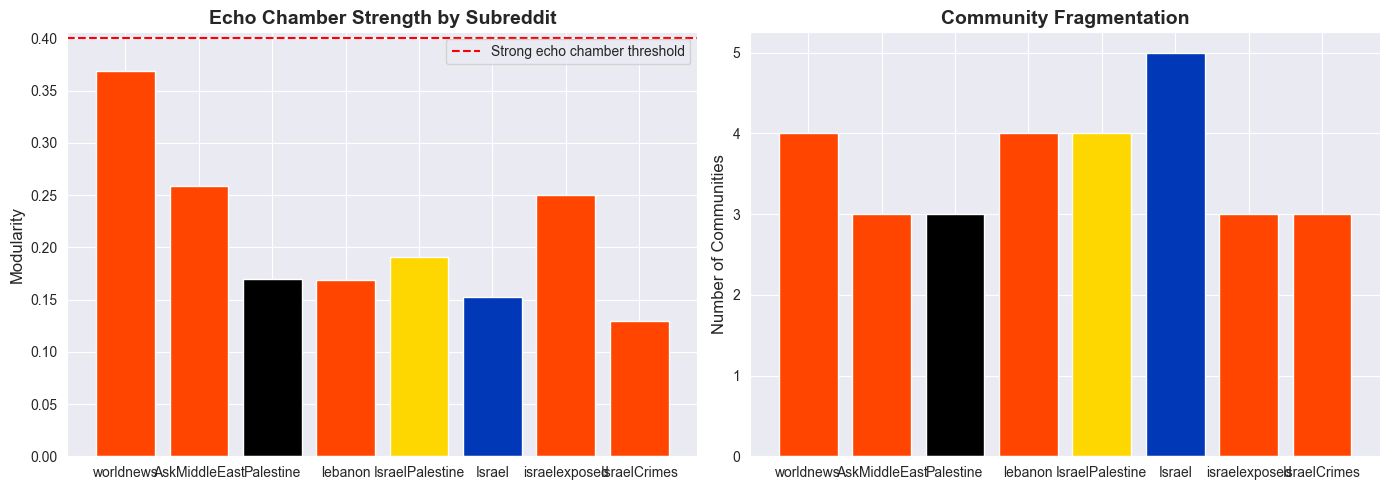


INTERPRETATION:
worldnews            | Modularity: 0.369 | MODERATE echo chambers
AskMiddleEast        | Modularity: 0.259 | WEAK echo chambers
israelexposed        | Modularity: 0.250 | WEAK echo chambers
IsraelPalestine      | Modularity: 0.191 | WEAK echo chambers
Palestine            | Modularity: 0.170 | WEAK echo chambers
lebanon              | Modularity: 0.169 | WEAK echo chambers
Israel               | Modularity: 0.153 | WEAK echo chambers
IsraelCrimes         | Modularity: 0.129 | WEAK echo chambers


In [8]:
if echo_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Modularity comparison
    subreddits = list(echo_results.keys())
    modularities = [echo_results[s]['modularity'] for s in subreddits]

    colors = []
    for sub in subreddits:
        if sub == 'Israel':
            colors.append('#0038B8')
        elif sub == 'Palestine':
            colors.append('#000000')
        elif sub == 'IsraelPalestine':
            colors.append('#FFD700')
        else:
            colors.append('#FF4500')

    ax1.bar(subreddits, modularities, color=colors)
    ax1.axhline(y=0.4, color='r', linestyle='--', label='Strong echo chamber threshold')
    ax1.set_ylabel('Modularity', fontsize=12)
    ax1.set_title('Echo Chamber Strength by Subreddit', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.set_ylim(0, max(modularities) * 1.1)

    # Community count
    communities = [echo_results[s]['num_communities'] for s in subreddits]
    ax2.bar(subreddits, communities, color=colors)
    ax2.set_ylabel('Number of Communities', fontsize=12)
    ax2.set_title('Community Fragmentation', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    sorted_results = sorted(echo_results.items(),
                           key=lambda x: x[1]['modularity'],
                           reverse=True)

    for sub, metrics in sorted_results:
        echo_strength = "STRONG" if metrics['modularity'] > 0.4 else "MODERATE" if metrics['modularity'] > 0.3 else "WEAK"
        print(f"{sub:20s} | Modularity: {metrics['modularity']:.3f} | {echo_strength} echo chambers")


HYPOTHESIS 14: POLARIZATION IN R/WORLDNEWS

Hypothesis: The author network in r/worldnews will reveal large,
disconnected clusters of users (those who comment on pro-Israel posts vs.
those who comment on pro-Palestine posts). "Bridging" users who comment on
both sets will be rare.

In [ ]:
df_worldnews = df[df['subreddit'] == 'worldnews'].copy()

# Sample if too large
MAX_SUBMISSIONS = 10000
if df_worldnews['submission_id'].nunique() > MAX_SUBMISSIONS:
    top_threads = df_worldnews['submission_id'].value_counts().head(MAX_SUBMISSIONS).index
    df_worldnews = df_worldnews[df_worldnews['submission_id'].isin(top_threads)]

print(f"Analyzing {len(df_worldnews):,} comments")
print(f"  Authors: {df_worldnews['author'].nunique():,}")
print(f"  Submissions: {df_worldnews['submission_id'].nunique():,}")

# Build author co-participation graph
g_worldnews = build_thread_coparticipation_graph(df_worldnews, min_shared_threads=2)

if g_worldnews and g_worldnews.vcount() > 0:
    print(f"\nAuthor network: {g_worldnews.vcount():,} nodes, {g_worldnews.ecount():,} edges")

    # Detect communities (polarized clusters)
    communities = g_worldnews.community_multilevel(weights='weight')
    modularity = g_worldnews.modularity(communities, weights='weight')

    print(f"Communities detected: {len(communities)}")
    print(f"Modularity: {modularity:.3f}")

    # Find largest communities
    comm_sizes = [len(c) for c in communities]
    top_comms = sorted(enumerate(comm_sizes), key=lambda x: x[1], reverse=True)[:5]

    print(f"\nTop 5 communities by size:")
    for i, (comm_id, size) in enumerate(top_comms, 1):
        print(f"  {i}. Community {comm_id}: {size:,} authors ({size/g_worldnews.vcount()*100:.1f}%)")

    # Calculate bridging: users in top 10% of betweenness
    print(f"\nCalculating bridging metrics...")
    betweenness = g_worldnews.betweenness(weights='weight', directed=False)
    threshold = np.percentile(betweenness, 90)
    bridgers = sum(1 for b in betweenness if b >= threshold)
    print(f"  Bridging users (top 10% betweenness): {bridgers} ({bridgers/g_worldnews.vcount()*100:.1f}%)")

else:
    print("Insufficient data for network analysis")

Analyzing 3,309,024 comments
  Authors: 38,451
  Submissions: 10,000


HYPOTHESIS 15: POWER USERS

Hypothesis: In the r/worldnews user network, the nodes with the highest
degree centrality (most connections) will be the most active commenters.

In [ ]:
if g_worldnews and g_worldnews.vcount() > 0:
    degree = g_worldnews.degree()
    g_worldnews.vs['degree'] = degree

    # Get top 20 power users
    top_indices = sorted(range(len(degree)), key=lambda i: degree[i], reverse=True)[:20]

    print(f"\nTop 20 power users by network centrality:")
    print(f"{'Rank':<5} {'Author':<25} {'Network Degree':<15} {'Comments':<10} {'Avg Score':<10}")
    print("-" * 75)

    for i, idx in enumerate(top_indices, 1):
        user = g_worldnews.vs[idx]['name']
        deg = degree[idx]

        # Get their actual comment count
        comment_count = len(df_worldnews[df_worldnews['author'] == user])
        avg_score = df_worldnews[df_worldnews['author'] == user]['score'].mean()

        print(f"{i:<5} {user:<25} {deg:<15} {comment_count:<10} {avg_score:<10.3f}")

    # Correlation between degree and comment count
    author_degrees = {g_worldnews.vs[i]['name']: degree[i] for i in range(g_worldnews.vcount())}
    author_comments = df_worldnews['author'].value_counts().to_dict()

    common_authors = set(author_degrees.keys()) & set(author_comments.keys())
    degrees_list = [author_degrees[a] for a in common_authors]
    comments_list = [author_comments[a] for a in common_authors]

    correlation = np.corrcoef(degrees_list, comments_list)[0, 1]
    print(f"\nCorrelation between network degree and comment count: {correlation:.3f}")
    print(f"  (>0.7 = high correlation, power users are simply most active)")


HYPOTHESIS 16: TIMEZONE ACTIVITY

Hypothesis: By inferring user timezones from posting times, we can measure
whether users interact more with same-timezone or cross-timezone users.

In [ ]:
df['hour'] = df['created'].dt.hour
user_avg_hour = df.groupby('author')['hour'].mean()

def estimate_timezone(hour):
    # Assume peak activity around 12-21 local time (average ~16:30)
    local_hour = int(hour - 16.5)
    return f"UTC{local_hour:+03d}:00"

user_timezones = user_avg_hour.apply(estimate_timezone)
print(f"\nEstimated timezones for {len(user_timezones):,} authors")

# Distribution of timezones
tz_dist = user_timezones.value_counts().head(10)
print(f"\nTop 10 timezones:")
for tz, count in tz_dist.items():
    print(f"  {tz}: {count:,} authors ({count/len(user_timezones)*100:.1f}%)")


In [ ]:
if g_worldnews and g_worldnews.vcount() > 0:
    for v in g_worldnews.vs:
        if v['name'] in user_timezones.index:
            v['timezone'] = user_timezones[v['name']]
        else:
            v['timezone'] = 'Unknown'

    # Calculate timezone homophily
    same_tz = 0
    diff_tz = 0

    for e in g_worldnews.es:
        source_tz = g_worldnews.vs[e.source]['timezone']
        target_tz = g_worldnews.vs[e.target]['timezone']

        if source_tz != 'Unknown' and target_tz != 'Unknown':
            if source_tz == target_tz:
                same_tz += 1
            else:
                diff_tz += 1

    total = same_tz + diff_tz
    if total > 0:
        tz_homophily = same_tz / total
        print(f"\nTimezone homophily in r/worldnews: {tz_homophily:.3f}")
        print(f"  Same timezone: {same_tz:,} edges ({same_tz/total*100:.1f}%)")
        print(f"  Different timezone: {diff_tz:,} edges ({diff_tz/total*100:.1f}%)")
        print(f"\nInterpretation: {'Users cluster by timezone' if tz_homophily > 0.6 else 'Cross-timezone interaction is common'}")


HYPOTHESIS 17: IDEOLOGICAL BRIDGING

Hypothesis: In r/IsraelPalestine, users with high betweenness centrality
("bridging" users who connect otherwise separate communities) will be
different from simply the most active users.

In [ ]:
df_debate = df[df['subreddit'] == 'IsraelPalestine'].copy()

if len(df_debate) > 0:
    print(f"Analyzing {len(df_debate):,} comments from {df_debate['author'].nunique():,} authors")

    g_debate = build_thread_coparticipation_graph(df_debate, min_shared_threads=2)

    if g_debate and g_debate.vcount() > 0:
        print(f"Network: {g_debate.vcount():,} nodes, {g_debate.ecount():,} edges")

        # Calculate betweenness centrality (bridging measure)
        print("Calculating betweenness centrality...")
        betweenness = g_debate.betweenness(weights='weight', directed=False)
        g_debate.vs['betweenness'] = betweenness

        # Also calculate degree for comparison
        degree = g_debate.degree()
        g_debate.vs['degree'] = degree

        # Get top bridging users
        top_bridgers_idx = sorted(range(len(betweenness)),
                                  key=lambda i: betweenness[i],
                                  reverse=True)[:20]

        print(f"\nTop 20 bridging users (by betweenness centrality):")
        print(f"{'Rank':<5} {'Author':<25} {'Betweenness':<15} {'Degree':<10} {'Comments':<10}")
        print("-" * 75)

        for i, idx in enumerate(top_bridgers_idx, 1):
            user = g_debate.vs[idx]['name']
            bc = betweenness[idx]
            deg = degree[idx]
            comments = len(df_debate[df_debate['author'] == user])

            print(f"{i:<5} {user:<25} {bc:<15.2f} {deg:<10} {comments:<10}")

        # Compare to high-degree users
        top_degree_idx = sorted(range(len(degree)),
                               key=lambda i: degree[i],
                               reverse=True)[:20]

        # How many overlap?
        bridgers_set = set(top_bridgers_idx)
        degree_set = set(top_degree_idx)
        overlap = len(bridgers_set & degree_set)

        print(f"\nOverlap between top bridgers and top degree users: {overlap}/20")
        print(f"  (Lower overlap suggests bridgers are qualitatively different from just active users)")

        # Community structure comparison
        communities = g_debate.community_multilevel(weights='weight')
        modularity = g_debate.modularity(communities, weights='weight')

        print(f"\nCommunity structure:")
        print(f"  Communities: {len(communities)}")
        print(f"  Modularity: {modularity:.3f}")

    else:
        print("Insufficient data for network analysis")
else:
    print("No data for IsraelPalestine subreddit")

In [ ]:
if echo_results:
    print("\nECHO CHAMBERS (Hypothesis 13):")
    print("Expected: r/Israel and r/Palestine > r/IsraelPalestine")
    print("-" * 80)

    # Sort by modularity
    sorted_results = sorted(echo_results.items(),
                           key=lambda x: x[1]['modularity'],
                           reverse=True)

    for sub, metrics in sorted_results:
        echo_strength = "STRONG" if metrics['modularity'] > 0.4 else "MODERATE" if metrics['modularity'] > 0.3 else "WEAK"
        print(f"{sub:20s} | Modularity: {metrics['modularity']:.3f} | {echo_strength} echo chambers")

    print("\nInterpretation:")
    print("  - Higher modularity indicates users cluster into separate groups")
    print("  - Lower modularity suggests more cross-group interaction")

print("\n" + "="*80)
print("DATA LIMITATIONS & NOTES")
print("="*80)
print("  - This analysis uses 'thread co-participation' as a proxy for interactions")
print("  - True reply networks would require parent_id -> parent_author mapping")
print("  - Sentiment analysis requires additional NLP processing of 'body' column")
print("  - Results are based on top 50K most active authors")